<a href="https://colab.research.google.com/github/Haobo-Yang/Project3STAT5243/blob/main/STAT5243_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT5243 Project3

##Section 1: Environment and Data Preparation

In [ ]:
import os
import PIL
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models import ResNet18_Weights
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430

In [ ]:
MY_DATA_DIR="__MACOSX"
def load_image_list(filename):
    """
    Load a list of image filenames from a text file.
    Each line in the file contains one image filename.
    """
    with open(filename,'r') as image_list_f:
        return [line.strip() for line in image_list_f]
FLICKR_PATH="./"

In [ ]:
train_list = load_image_list(os.path.join(FLICKR_PATH, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.devImages.txt'))
test_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.testImages.txt'))

In [ ]:
IMG_PATH = os.path.join(FLICKR_PATH, "Flicker8k_Dataset")

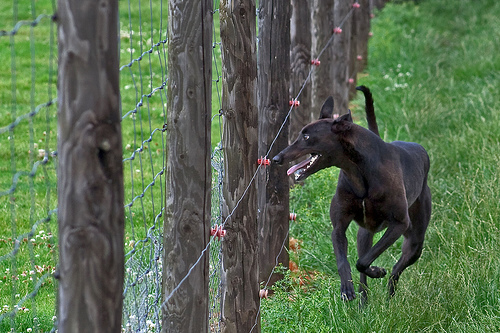

In [ ]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image #test the accessibility

##Section 2: Loading Descriptions

In [ ]:
def load_descriptions(file_path):
    descriptions = {}
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            img_id, caption = line.split('\t')
            """
            Load image descriptions from a text file.
            The file format is:
            image_name.jpg#0 <tab> caption text
            We strip the "#X" part and store all captions under the image key.
            """
            img_id = img_id.split('#')[0]

            if img_id not in descriptions:
                descriptions[img_id] = []
            descriptions[img_id].append(caption)
    return descriptions

desc_file = os.path.join(FLICKR_PATH, "Flickr8k.token.txt")
descriptions = load_descriptions(desc_file)

In [ ]:
# Check an example image and its descriptions
example_img = dev_list[20]
if example_img in descriptions:
    print("Image ID:", example_img)
    print("Descriptions:")
    for d in descriptions[example_img]:
        print("-", d)
else:
    print(f"No descriptions found for {example_img}")

Image ID: 3693961165_9d6c333d5b.jpg
Descriptions:
- A black dog is looking through the fence .
- A brown dog runs along a fence .
- A dark brown dog is running along a fence outside .
- A large black dog runs along a fence in the grass .
- The brown greyhound dog walks on green grass and looks through a fence .


## Section 3: Model and Tokenizer Setup

In [ ]:
!pip install transformers

from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Vision-Encoder-Decoder model
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Configure special tokens and generation parameters
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
max_length = 40
num_beams = 4


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

##Section 4: Dataset Class

In [ ]:
class Flickr8kHFDataset(Dataset):
    """
    A custom dataset class for Flickr8k that:
    - Takes a list of image filenames and a dict of image descriptions.
    - For each image, it pairs with all its captions.
    - Uses the feature_extractor to process images into pixel_values.
    - Uses the tokenizer to process captions into input_ids and attention_masks.
    """
    def __init__(self, img_list, img_dir, descriptions, feature_extractor, tokenizer, max_length=40):
        self.img_list = img_list
        self.img_dir = img_dir
        self.descriptions = descriptions
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

        # (image_path, caption)
        self.data = []
        for img_name in self.img_list:
            if img_name in self.descriptions:
                caps = self.descriptions[img_name]
                # Each image usually has 5 captions.
                for cap_tokens in caps:
                    caption_str = " ".join(cap_tokens)
                    self.data.append((img_name, caption_str))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, caption_str = self.data[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        if image.mode != "RGB":
            image = image.convert("RGB")

        # Convert image to pixel values
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values

        # Tokenize the caption
        tokens = self.tokenizer(caption_str, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")
        input_ids = tokens.input_ids
        attention_mask = tokens.attention_mask
        labels = input_ids.clone()

        return pixel_values.squeeze(0), input_ids.squeeze(0), attention_mask.squeeze(0), labels.squeeze(0)


##Section 5: DataLoader and Optimizer Setup

In [ ]:
IMG_PATH = os.path.join(FLICKR_PATH, "Flicker8k_Dataset")
train_dataset = Flickr8kHFDataset(train_list, IMG_PATH, descriptions, feature_extractor, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)



##Section 6: Training

In [ ]:
from tqdm import tqdm
model.train()
for epoch in range(1): # Please take about 5 epochs to get a more accurate score for caption. I chose 1 because one epoch takes about half an hour to run.
    total_loss = 0
    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        # Unpack the batch here
        pixel_values, input_ids, attention_mask, labels = batch
        pixel_values = pixel_values.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # forward to pixel_values&labels
        outputs = model(pixel_values=pixel_values, labels=labels, decoder_attention_mask=attention_mask)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch loss: {total_loss/len(train_loader)}")

Epoch 1: 100%|██████████| 1875/1875 [30:30<00:00,  1.02it/s]

Epoch loss: 0.8897815803686778


##Section 7: Evaluation / Inference

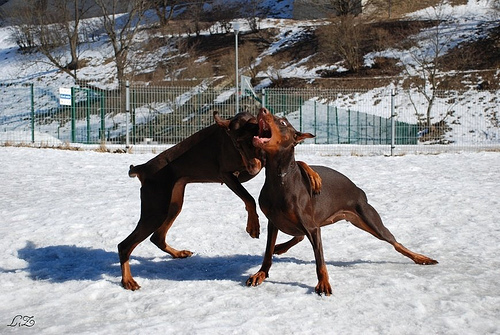

Generated Caption:  A   b l a c k   a n d   b r o w n   d o g   i s   r u n n i n g 


In [ ]:
from IPython.display import display
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()
test_image = os.path.join(IMG_PATH, test_list[0])
image = Image.open(test_image).convert("RGB")
display(image)
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

# Generate a caption for a single test image
output_ids = model.generate(pixel_values, max_length=max_length, num_beams=num_beams)
pred_caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Generated Caption: ", pred_caption)